# Coding Challenge (Fall 2021)

This coding challenge requested the overall sentiment of the text in `input.txt`.
I chose to use the VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tool to analyze the input text.
The benefits and drawbacks of this choice and my analysis are explained in the [conclusions](#Conclusions) and [limitations](#Limitations) sections, respectively.

## Background

I have plenty of experience using sentiment analysis tools, but this challenge presented a unique problem that I had not encountered before.
Most accessible sentiment analysis tools target modern language, especially informal and emotionally impacted text.
This can be attributed to their primary use-case: analysis of social media or customer feedback/interaction.
For example, one of the most commonly used pre-labeled sentiment analysis training sets is comprised of movie reviews.
The input file is composed of two excerpts, one from *The Sand and The Sieve* by Ray Bradbury and *The Autobiography of Benjamin Franklin*.
While helpful to companies trying to gauge customer satisfaction, the existing tools are not general enough to handle the style of language used by these excerpts.
As such, the main challenge presented by this problem lies in the interpretation of the input data rather than the sentiment analysis itself.

## Implementations

All implementations will use the VADER sentiment analysis tool.

In [10]:
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

file = open('input.txt', mode='r')
data = file.read()
file.close()

### Naive

Since the assignment was to analyze the sentiment of the entirety of the text in the input file, throwing the entirety of the text into the VADER sentiment analysis tool is the fastest way to generate *some* result.

In [11]:
scores = analyzer.polarity_scores(data)
print(f"compound score = {scores['compound']}")

compound score = 0.9982


This score represents an analysis of the entire input file. It is a *normal score* produced by VADER; 1 would mean entirely positive and -1 would mean entirely negative.

Despite being an exhibition of bare minimum effort as a user of the library, it generates a surprisingly good result.

While most of the file registers as neutral, VADER judges the file to be much more positive than it is negative; this is the conclusion reflected in the compound score, as it is very close to 1.

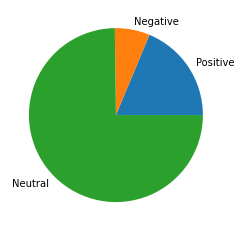

In [12]:
plt.pie(x=[scores[key] for key in ['pos', 'neg', 'neu']],
        labels=['Positive', 'Negative', 'Neutral'])
plt.show()

While this seems hard to believe, reading the text itself offers an explanation.
The second excerpt describes Benjamin Franklin's "person and character" in great detail.
The thorough positivity of the description, then, follows from its authorship.

This simple score technically answers the question proposed by the challenge, but the complexity of the inputs provided requires a more sophisticated analysis.

### Paragraph Analysis

While this technique has been applied to the whole input text, the disparity in source between the two excerpts prompts individual analysis of each excerpt.

This can easily be accomplished by applying the same analysis to both paragraphs.

In [13]:
# split the input into two paragraphs
bradbury_data, franklin_data = data.split('\n\n', maxsplit=2)

# score each one individually
bradbury_score = analyzer.polarity_scores(bradbury_data)
print(f"Bradbury ({bradbury_data[:30]}...): {bradbury_score['compound']}")

franklin_score = analyzer.polarity_scores(franklin_data)
print(f"Franklin ({franklin_data[:30]}...): {franklin_score['compound']}")

Bradbury ("Stop blushing. I'm not needli...): 0.521
Franklin (I think you may like to know s...): 0.9981


These are starkly discrete scores. The Franklin excerpt generated a far more positive score that the Bradbury excerpt; the latter registers almost neutral.
A score generated from this finer-grained analysis is significantly different.

In [14]:
# average the score of the two paragraphs, accounting for weight based on size
round((bradbury_score['compound'] * len(bradbury_data) + franklin_score['compound'] * len(franklin_data)) / (len(bradbury_data) + len(franklin_data)), 3)

0.81

This result reveals deeper complexities in the input data. While it is subjectively obvious that the autobiography is very positive,
the novel attempts to relate more complex emotions. In the context of the story, Beatty is using Montag's love of books to get a rise out of the book-loving protagonist.
While there is no way for our analyzer to know this, a good score would reflect this sentiment.

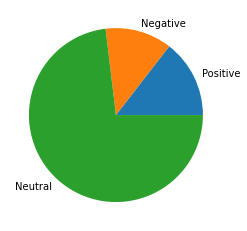

In [15]:
# plot scores from the Bradbury excerpt
plt.pie(x=[bradbury_score[key] for key in ['pos', 'neg', 'neu']],
        labels=['Positive', 'Negative', 'Neutral'])
plt.show()

Unfortunately, it seems that the holistic approach to analysis is not able to detect the passion and mischief in Beatty's words.
In order to improve the analysis, it is necessary to dig deeper into the data.

### Sentence Tokenization

An easy way to extract more depth using a similarly easy analysis method is to analyze the input on a sentence by sentence basis.
Since we are investigating the first paragraph, we will only perform sentence-level analysis on that excerpt.

Using the NLTK (Natural Language ToolKit), a Python library for Natural language processing, it is simple to tokenize the sentences in this paragraph.

In [16]:
from nltk import tokenize

sentences = tokenize.sent_tokenize(bradbury_data)
# print some of the tokenized sentences
print('\n'.join(sentences[:3]))
print('...')

"Stop blushing.
I'm not needling, really I'm not.
Do you know, I
had a dream an hour ago.
...


Now that we have split the paragraph into sentences, we can perform a more fine-grained analysis.

Coloring the text with a utility function will enable a human viewer to visually understand the results of the analysis.

In [17]:
def color(text, sentiment):
        color_code = None
        if sentiment > 0.5:
                color_code = '32' # green for positive
        elif sentiment < -0.5:
                color_code = '31' # red for negative
        if color_code is not None and abs(sentiment) > 0.8:
                color_code = '1;' + color_code # bold for very positive/negative
        return f"\x1b[{color_code}m{text}\x1b[m" if color_code else text

print(f'These colors will mark text as {color("neutral", 0.0)}, {color("positive", 0.6)}, {color("negative", -0.6)}, {color("very positive", 0.99)}, or {color("very negative", -0.99)}')

These colors will mark text as neutral, positive, negative, very positive, or very negative


The next step is to put them through the VADER analysis tool.

In [18]:
for sentence in sentences:
        print(color(sentence, analyzer.polarity_scores(sentence)['compound']), end=' ')

"Stop blushing. I'm not needling, really I'm not. Do you know, I
had a dream an hour ago. I lay down for a cat-nap and in this dream
you and I, Montag, got into a furious debate on books. You towered
with rage, yelled quotes at me. I calmly parried every thrust. Power, I
said, And you, quoting Dr. Johnson, said `Knowledge is more than
equivalent to force!' And I said, `Well, Dr. Johnson also said, dear boy,
that "He is no wise man that will quit a certainty for an uncertainty.'" Stick with the fireman, Montag. All else is dreary chaos!" "Don't listen," whispered Faber. "He's trying to confuse. He's
slippery. Watch out!" Beatty chuckled. "And you said, quoting, `Truth will come to light,
murder will not be hid long!' And I cried in good humour, 'Oh God, he
speaks only of his horse!' And `The Devil can cite Scripture for his
purpose.' And you yelled, 'This age thinks better of a gilded fool, than
of a threadbare saint in wisdom's school!' And I whispered gently, 'The
dignity of truth is 

This analysis reveals an occurrence that was previously hidden to us! Of the sentences marked with a positive or negative sentiment, there is a specific pattern.
Beatty, the main speaker in this excerpt, uses negative sentiment when talking about Montag, but positive sentiment when talking about himself.
While VADER cannot seem to parse the relationships in most of the dialogue, the successful results uncover details that would otherwise only be discoverable through literary analysis.

## Conclusions

Drawing conclusions from compound input data like the file provided proved difficult, but I learned some valuable lessons from this coding challenge.

To summarize the results of the analysis: the holistic result came out to around 0.99, but this score was somewhat inaccurate; the paragraph-wise analysis revealed that the autobiography was very positive (understandably) but that our analyzer was having trouble understanding the novel excerpt, so its score of 0.81 was still not completely; in the third analysis, it was revealed that this was because it was not able to make out the sentiment of most of the sentences in the excerpt; however, from that analysis, a result of literary importance was gleaned.

Overall, the sentiment of the text is positive. This is mostly due to the extremely positive autobiography of Benjamin Franklin, in which he describes himself with a long list of compliments. The first paragraph is more complex. The speaker has a mixed sentiment: it is positive when he is referring to himself but negative when referring to the object of his story.

I consider this analysis an adequate solution to the proposed challenge because it appropriately determines the sentiment of the given input with multiple levels of granularity, explains what the seemingly arbitrary numerical scores mean, and compares and contrasts results from the analysis with intuitive and contextual analyses of the input text.

## Limitations

My initial plans for this coding challenge included a port of the VADER sentiment analysis library to Rust and an original algorithm to extract quotations from the text for better handling of context and textual relationships.
Given enough time, I'm sure these plans would have been an enjoyable and fruitful endeavor, but due to time requirements, my solution to this challenge is limited to an existing library and some basic natural language processing.
My algorithm of choice, VADER, is not meant to handle literary data; it is instead specifically designed for analyzing the slang and idioms of modern interactions on social media.
This limitation could be overcome by training a similar model using a lexicon more suited to the target text.

## License

This notebook makes use of the VADER sentiment analysis tool. As such, it is provided under the MIT license, with credit for VADER given to the following paper/author.

> Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

In performing this analysis, I made use of the [VADER python implementation](https://github.com/cjhutto/vaderSentiment) and the [jupyter reference](https://jupyterbook.org/content/code-outputs.html).